In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

# %pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def setupconfig(model, con, coupl, integrator, monitors, init_cond=None):
    ############## 6. Initialize Simulator #############
    # initialize simulator object
    sim = simulator.Simulator(model=model,
                              initial_conditions=init_cond,
                              connectivity=con,
                              coupling=coupl,
                              integrator=integrator,
                              monitors=monitors)
    configs = sim.configure()
    return sim, configs

In [3]:
print(regions)
#001
ez = ['ctx-rh-lateralorbitofrontal', 'ctx-rh-temporalpole']
pz = ['ctx-rh-superiorfrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-lateralorbitofrontal']

# 008
ez = ['Right-Amygdala', 'Right-Hippocampus']
pz = ['ctx-rh-superiortemporal', 'ctx-rh-temporalpole', 'ctx-rh-inferiortemporal',
     'ctx-rh-medialorbitofrontal', 'ctx-rh-lateralorbitofrontal']

# 013
ez = ['ctx-rh-fusiform']
pz = ['ctx-rh-inferiortemporal','Right-Hippocampus','Right-Amygdala', 
      'ctx-rh-middletemporal','ctx-rh-entorhinal']

# 014
ez = ['Left-Amygdala', 'Left-Hippocampus', 'ctx-lh-entorhinal', 'ctx-lh-fusiform',
     'ctx-lh-temporalpole','ctx-rh-entorhinal']
pz = ['ctx-lh-superiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-inferiortemporal',
     'ctx-lh-insula', 'ctx-lh-parahippocampal']



NameError: name 'regions' is not defined

# Run Actual Python File

Old params:
intialized hard coded parameters
epileptor_r = 0.0002#/1.5   # Temporal scaling in the third state variable
epiks = -1                  # Permittivity coupling, fast to slow time scale
epitt = 0.025               # time scale of simulation
epitau = 4                # Temporal scaling coefficient in fifth st var

#x0c value = -2.05
x0norm=-2.4
x0ez=-1.7
x0pz=-2.0

eznum = 1
pznum = 3
#depends on epileptor variables of interest: it is where the x2-y2 var is
varindex = [1]

######### Integrator Parameters ##########
#parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                0.0001, 0.0001, 0.])/3

In [4]:
# patient = 'id002_cj'
# patient = 'id001_ac'
patient = 'id008_gc'
# patient = 'id013_pg'

expname = 'exp005'
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')
metadatadir = os.path.join(root_dir, "metadata/")
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/',
                             expname)

# dir of the metadaa for this patient
project_dir = os.path.join(metadatadir, patient)
outputdir = os.path.join(outputdatadir)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
tvbsim.util.renamefiles(patient, project_dir)

use_subcort = 1
verts, normals, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)

print(patient)

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
id008_gc


In [14]:
factor = 1
samplerate = 1000*factor # Hz
sim_length = 60*samplerate    
period = 1./factor

######### Epileptor Parameters ##########
epileptor_r = 0.00035#/1.5   # Temporal scaling in the third state variable
epiks = -2                  # Permittivity coupling, fast to slow time scale
epitt = 0.05                   # time scale of simulation
epitau = 10                 # Temporal scaling coefficient in fifth st var

# x0c value = -2.05
x0norm=-2.35
x0ez=-2.35
x0pz=-2.35

# eznum = 1
# pznum = 1
movedist = 5

######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                      0.0001, 0.0001, 0.])

sim_params = {'r': epileptor_r,
            'epiks': epiks,
            'epitt': epitt,
            'epitau': epitau,
            'noise': noise_cov}
epi_params = {
            'r': epileptor_r,
            'ks': epiks,
            'tt': epitt,
            'tau': epitau,
            'x0norm': x0norm,
            'x0pz': x0pz,
            'x0ez': x0ez
            }
heun_params = { 'ts': heun_ts,
                'noise': noise_cov}

surf_params = dict()
surf_params['verts'] = verts
surf_params['normals'] = normals
surf_params['areas'] = areas
surf_params['regmap'] = regmap

####### Initialize files needed to 
# convert seeg.xyz to seeg.txt file
sensorsfile = os.path.join(project_dir, "seeg.txt")
gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
confile = os.path.join(project_dir, "connectivity.zip")

if 'id008' in patient:
    # 008
    ezregions = ['Right-Amygdala'] #, 'Right-Hippocampus']
    pzregions = ['ctx-rh-superiortemporal'] 
         #    , 'ctx-rh-temporalpole', 'ctx-rh-inferiortemporal',
         # 'ctx-rh-medialorbitofrontal', 'ctx-rh-lateralorbitofrontal']
elif 'id013' in patient:
    # 013
    ezregions = ['ctx-rh-fusiform']
    pzregions = ['ctx-rh-inferiortemporal']
        
# setup the simulation using params
epileptors, con, coupl, heunint, monitor, initcond = tvbsim.initsim.initializesim(period, epi_params, heun_params, 
                                                    confile, sensorsfile, gainmatfile, 
                                                    eznum=None, pznum=None, ezregion=ezregions, pzregion=pzregions,
                                                    surf_params=surf_params, movedist=movedist)
initcond=None
sim, config = setupconfig(epileptors, con, coupl, heunint, monitor, initcond)
times, epilepts, seegts = runsim(sim, sim_length)

('Moving onto current ez index: ', 47, ' at ', 'Right-Amygdala')
A3

elec label is A


 movecontact function summary: 

('Closest contact to ezregion: ', array([15.746 ,  7.5355, -3.4837]), ' is ', 'A3')
('That is located at: ', array([16.29, 11.04, -9.33]))
('It will move: ', [-0.146216219209354, -0.9419388606970255, 1.571367430815529])
('New location after movement is', array([16.14378378, 10.09806114, -7.75863257]), '\n')


 Am 5.0 from ez region! Should match movedist!

This electrode has this many electrode indices on it [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


In [15]:
######################## POST PROCESSING #################################
postprocessor = tvbsim.util.PostProcess(epilepts, seegts, times)

# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocessor.postprocts(samplerate)

# determine where norm, pz and ez are
ezindices = np.where(config.model.x0 == x0ez)[0]
pzindices = np.where(config.model.x0 == x0pz)[0]
pzindices = np.array([])

print(ezindices)
print(pzindices)

seizonsets = []
seizoffsets = []
allindices = np.append(ezindices, pzindices, axis=0).astype(int)
print(allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.2/5)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

lowcut = 0.1
highcut = 499.
fs = 1000.
# y = butter_highpass_filter(x, lowcut, fs, order=4)
seegts = tvbsim.util.butter_bandpass_filter(seegts, lowcut, highcut, fs, order=4)

# ######################## SAVING ALL DATA #################################
regions = config.connectivity.region_labels

ezregions = regions[ezindices]
if len(pzindices) > 0:
    pzregions = regions[pzindices]
else:
    pzregions = None
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': config.connectivity.centres,
    'seeg_contacts': config.monitors[1].sensors.labels,
    'seeg_xyz': config.monitors[1].sensors.locations,
    'ez': ezregions,
    'pz': pzregions,
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':seizonsets,
    'offsettimes':seizoffsets,
    'patient':patient,
    'simparams': sim_params
}

# initialize file directory to save simulation
filename = os.path.join(outputdir, patient+'_sim_nez'+str(len(ezindices))+\
                                    '_npz'+str(len(pzindices))+ '_dist' + str(movedist) + '.npz')
sys.stdout.write("\nProject directory for meta data is : " + project_dir)
sys.stdout.write("\nFile to be saved is: " + filename)

# save tseries
np.savez_compressed(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=meta)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
returning cuz prevoffset is nan!

Project directory for meta data is : /Users/adam2392/Documents/pydata/metadata/id008_gc
File to be saved is: /Users/adam2392/Documents/pydata/tvbforwardsim/exp005/id008_gc_sim_nez84_npz0_dist5.npz

In [9]:
# determine where norm, pz and ez are
ezindices = np.where(config.model.x0 == x0ez)[0]
pzindices = np.where(config.model.x0 == x0pz)[0]

seeg_labels = config.monitors[1].sensors.labels
ezregion = regions[ezindices]
pzregion = regions[pzindices]
print(ezregion)
print(ezindices)
# print(pzregion)

['Right-Amygdala']
[47]


In [16]:
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}


color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)

In [18]:
timebegin = 0

# ezindices = np.where(config.model.x0 == x0ez)[0]
# # pzindices = np.where(config.model.x0 == x0pz)[0]
pzindices = np.array([])

seizonsets = []
seizoffsets = []
allindices = np.append(ezindices, pzindices, axis=0).astype(int)
print(allindices)
settimes = postprocessor.getonsetsoffsets(zts[:,timebegin:], allindices, delta=0.5)
# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

# print(pzindices)
# print(settimes)
# print(seizonsets, seizoffsets)
toplot = zts[ezindices,:].squeeze()
# onset, offset = postprocessor.findonsetoffset(toplot[13000:], delta=0.2/5)

# rawplotter.initializefig(figsize=(14,10))
# rawplotter.plotzts(toplot[timebegin:], onsettimes=seizonsets, offsettimes=seizoffsets)
print(toplot.shape)
# print(onset,offset)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
returning cuz prevoffset is nan!
(84, 45000)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
ezreion is:  ['Right-Amygdala']
pzregion is:  []
time series shape is:  (84, 45000)


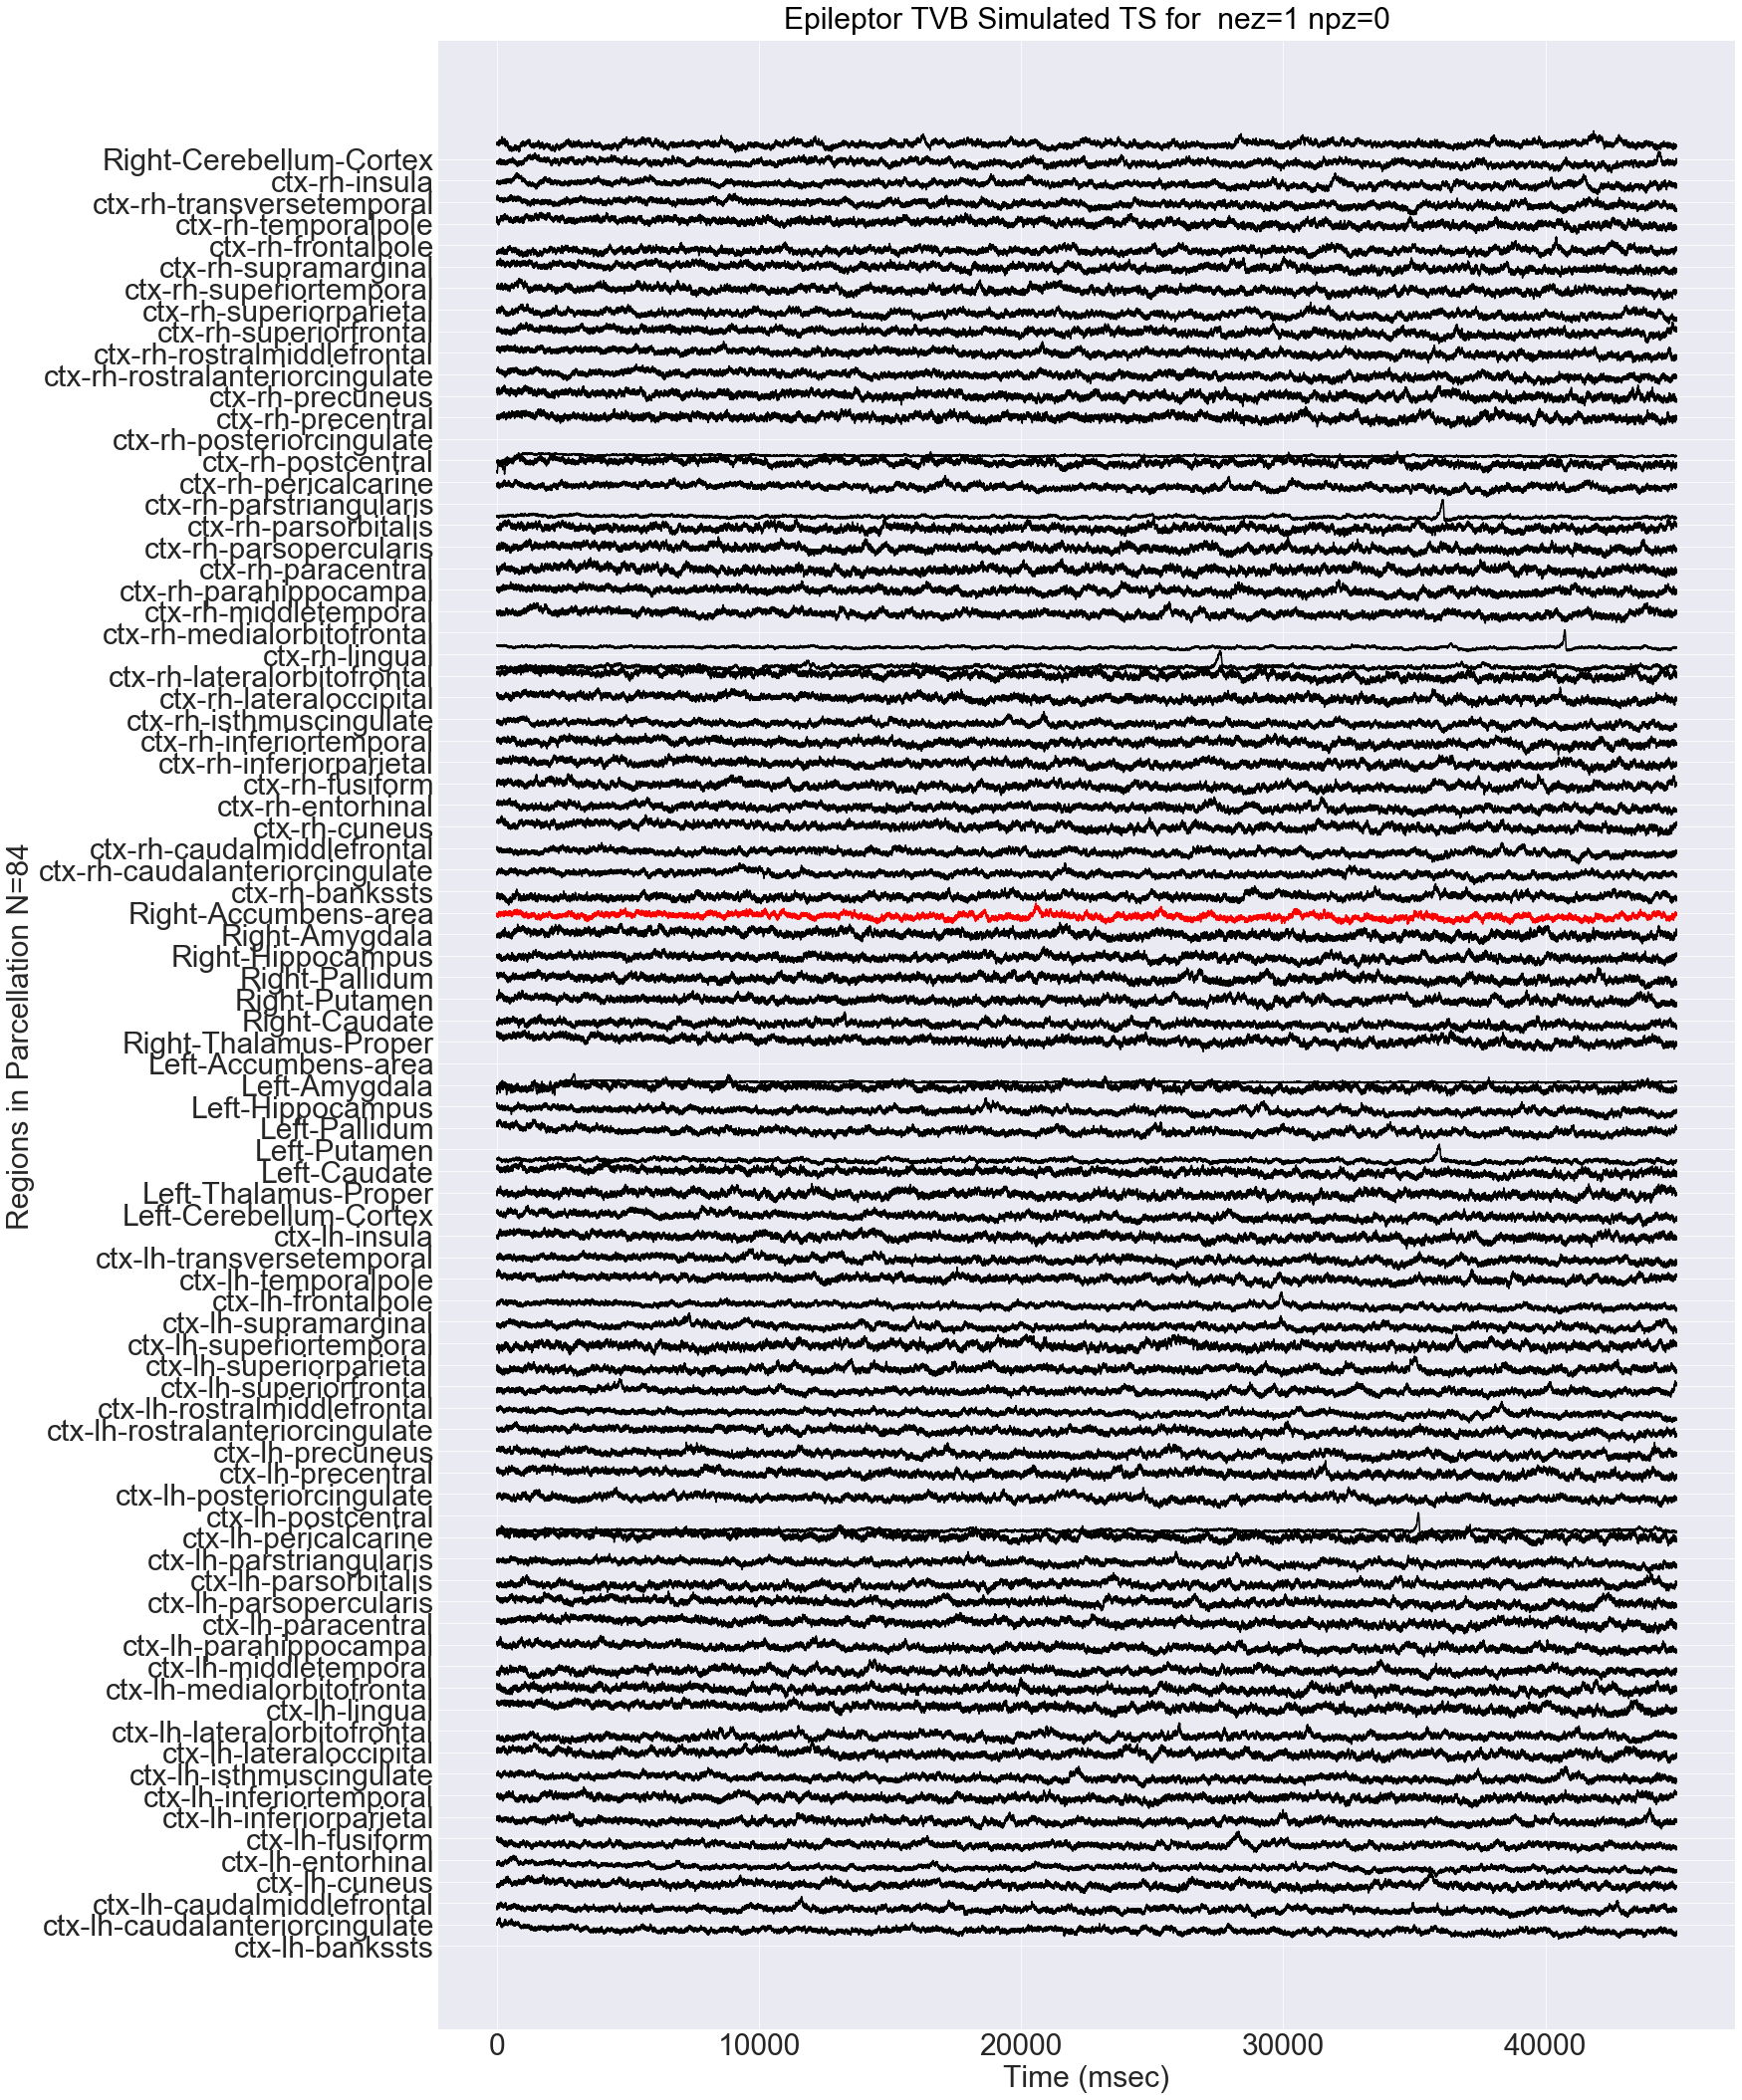

In [19]:
print meta['ezindices']
# timebegin = 15000
rawplotter.initializefig(figsize=(25,30))
epifig = rawplotter.plotepileptorts(epits[:,timebegin:], regions, ezregion, pzregion=[], \
                times=times, onsettimes=seizonsets, offsettimes=seizoffsets, plotsubset=False)

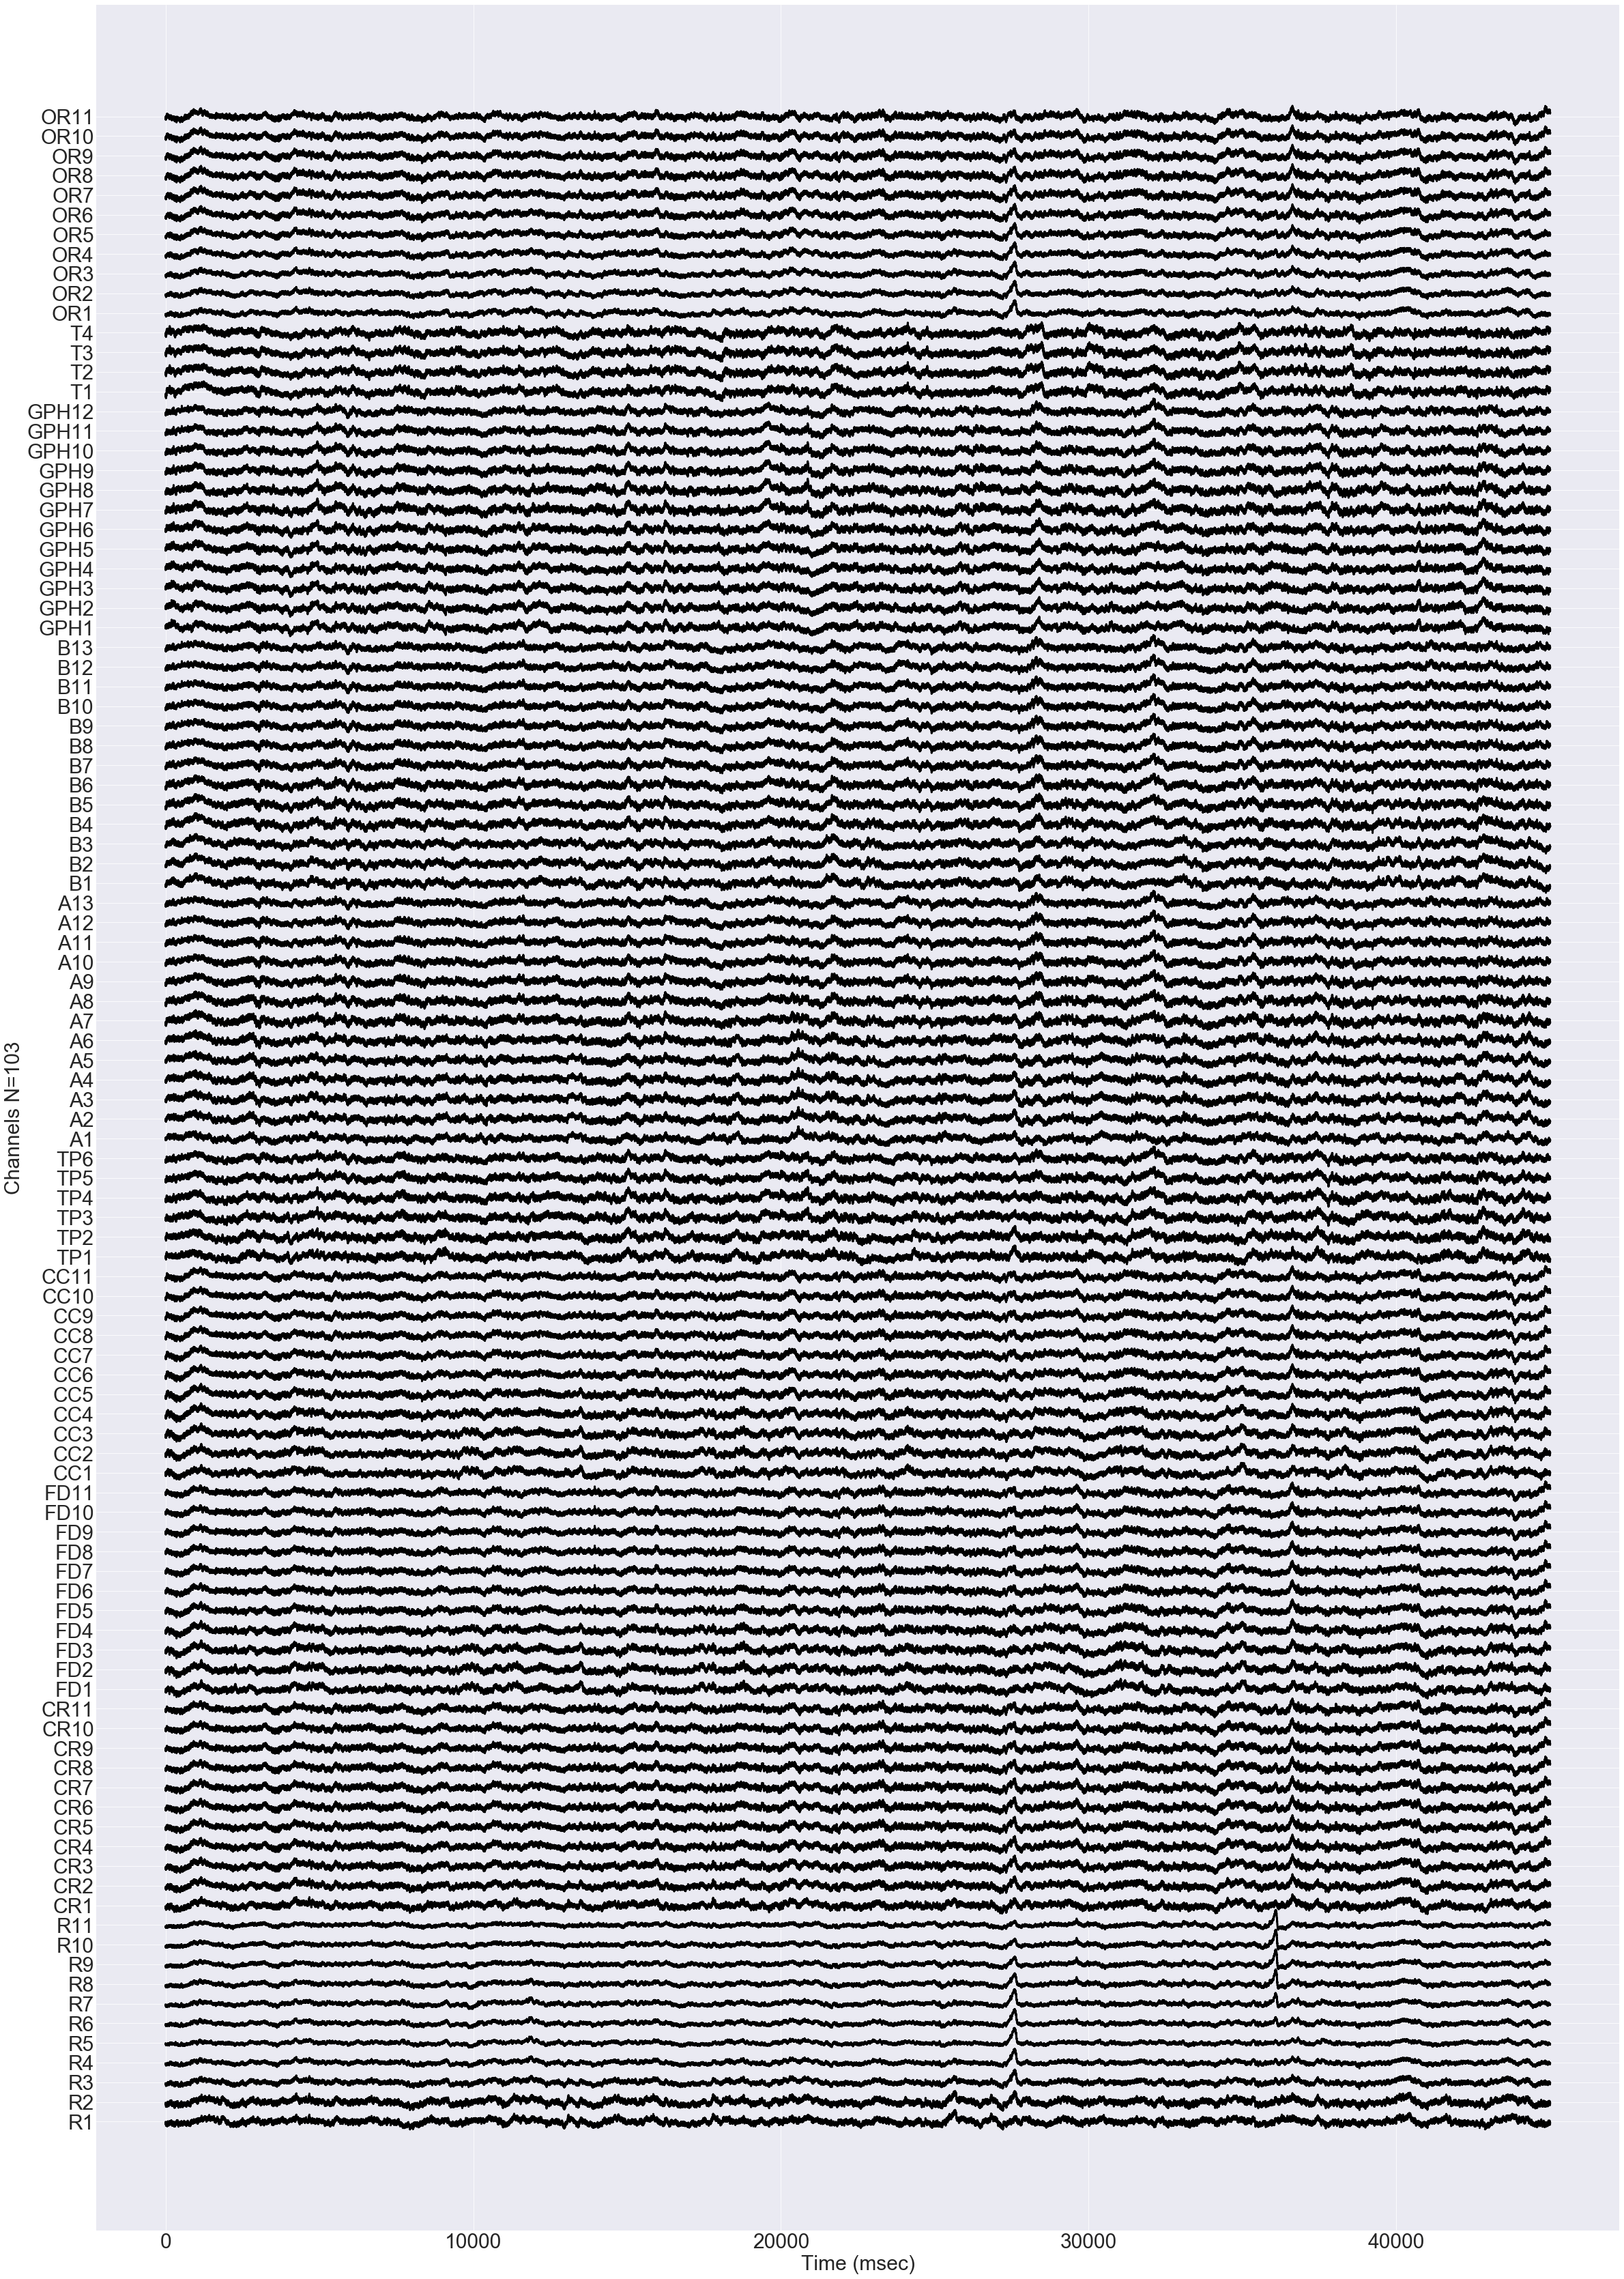

In [20]:
rawplotter.initializefig(figsize=(40, 60))
seegfig = rawplotter.plotseegts(seegts, seeg_labels, times, seizonsets, seizoffsets, plotsubset=False)

# rawplotter.initializefig(figsize=(20, 10))
# seegfig = rawplotter.plotseegts(y[:,10000:], seeg_labels, times, seizonsets, seizoffsets, plotsubset=True)

# toplotlabels = ["A1", "A2", "OR10", "OR1", "OR2", "TBP1"]
# rawplotter.initializefig(figsize=(20, 10))
# seegfig = rawplotter.plotseegchans(y[:,timebegin:], times, seeg_labels, 
#                     seizonsets, seizoffsets, toplotlabels=toplotlabels)

59
ez seeg index is:  []


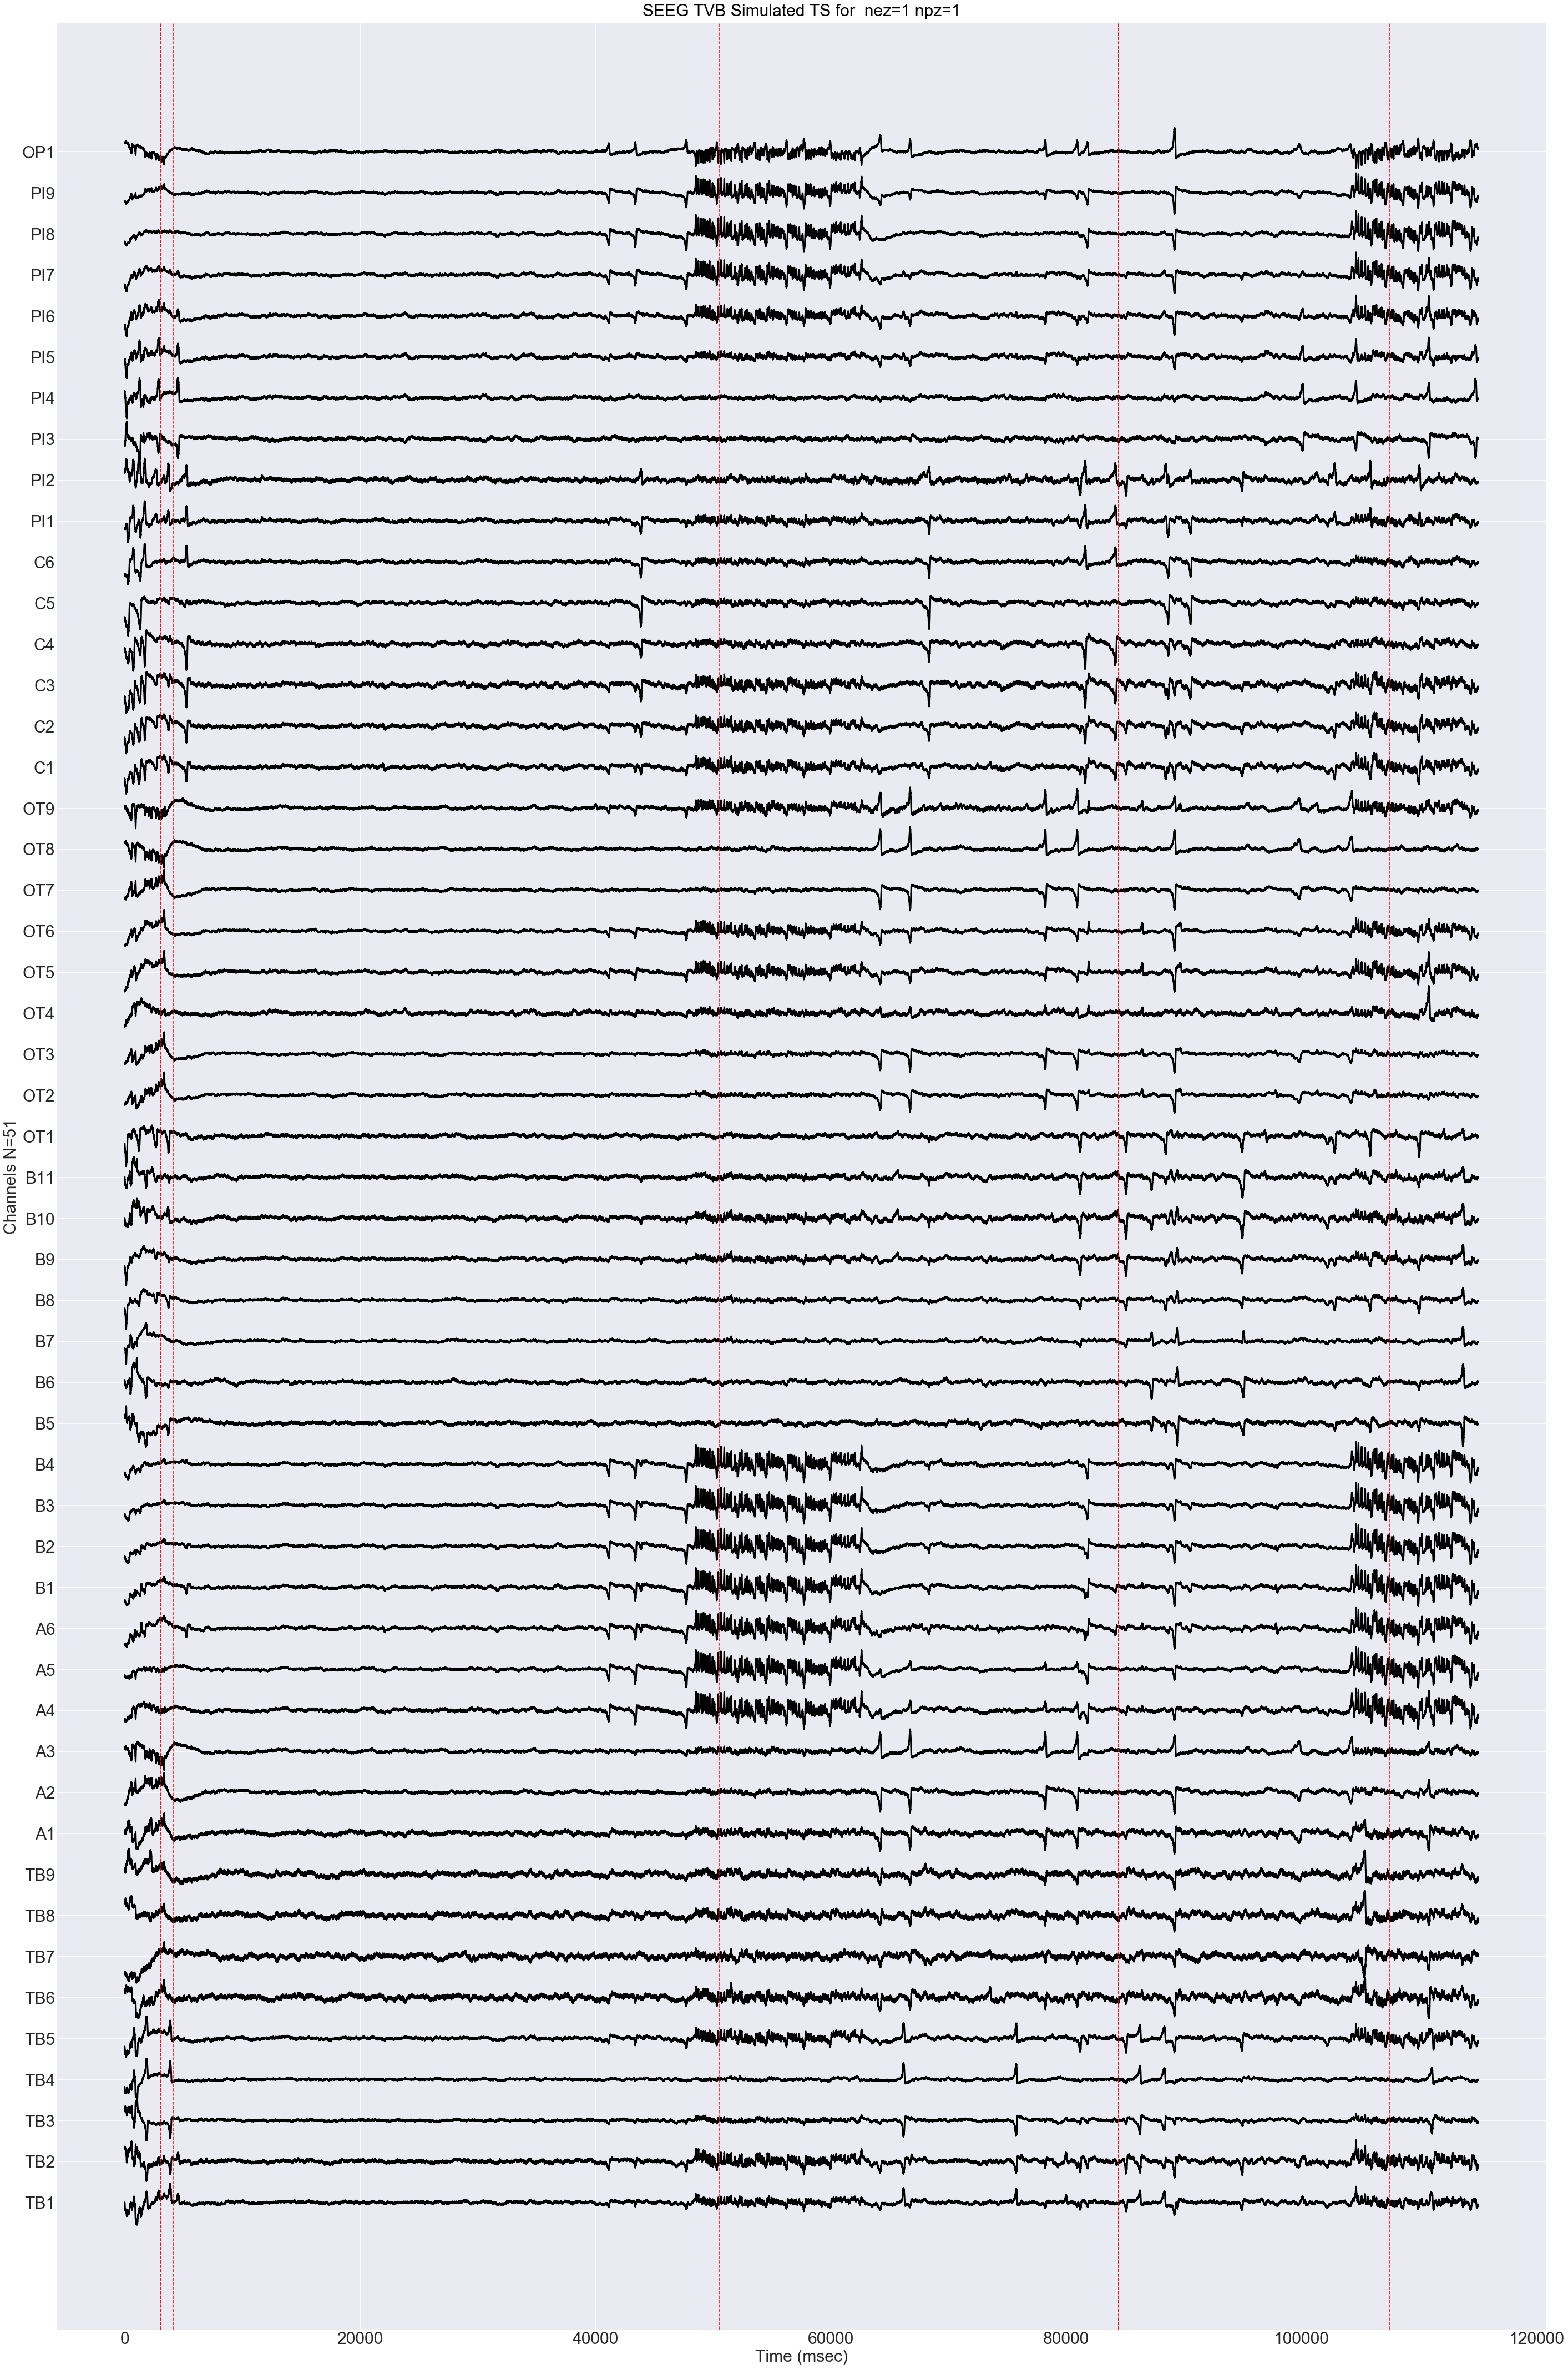

In [52]:
seeg_labels = meta['seeg_contacts']
# convert contacts into a list of tuples as data structure
contacts = []
for seeg_contact in seeg_labels:
    for idx, s in enumerate(seeg_contact):
        if s.isdigit():
            elec_label = seeg_contact[0:idx]
    contacts.append((elec_label, int(seeg_contact[len(elec_label):])))
print(len(contacts))

# compute the bipolar scheme
seegrecording = tvbsim.seegrecording.SeegRecording(contacts, y, samplerate)
biplabels = np.asarray(seegrecording.get_channel_names_bipolar())
bipseeg = seegrecording.get_data_bipolar()

rawplotter.initializefig(figsize=(40, 60))
seegfig = rawplotter.plotseegts(bipseeg[:,5000:], times, meta, seizonsets, seizoffsets, plotsubset=False)

[nan]
[]
ez seeg index is:  []


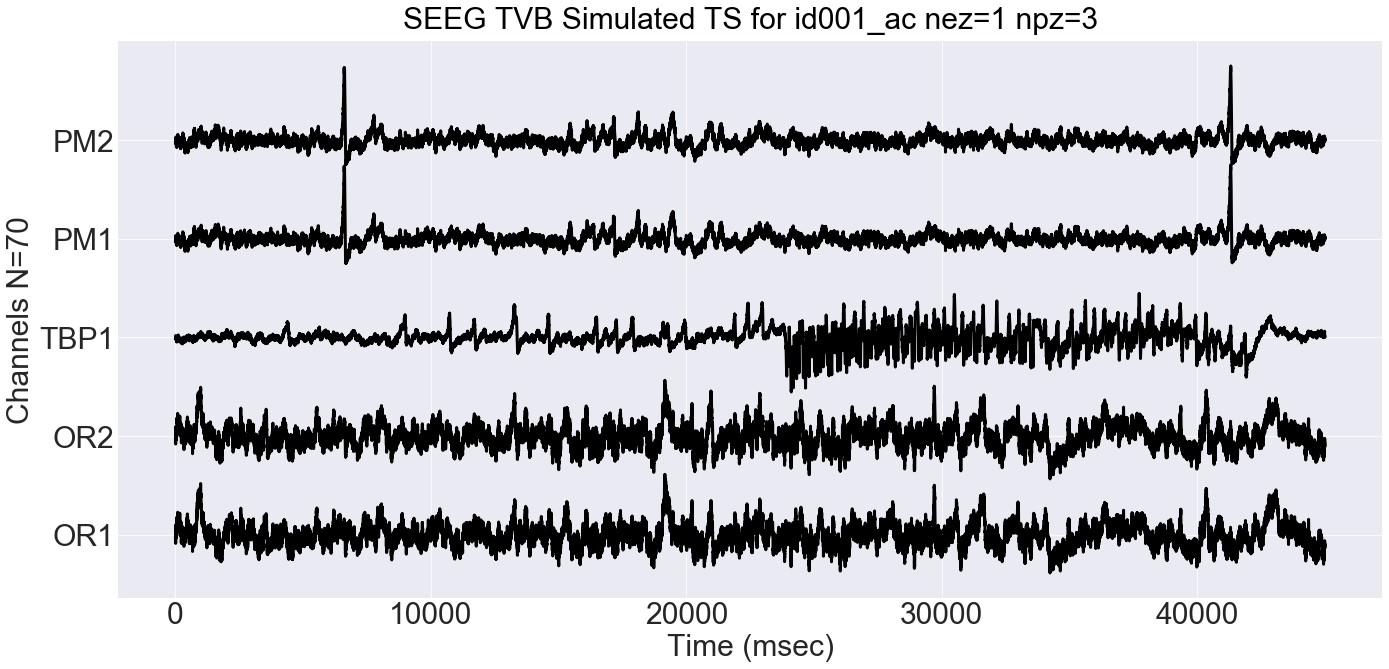

In [167]:
print(seizonsets)
print(seizoffsets)
toplotlabels = ["PM1", "PM2", "OF10", "OR1", "OR2", "TBP1"]
rawplotter.initializefig(figsize=(20, 10))
seegfig = rawplotter.plotseegchans(y, times, meta, onsettimes, 
                    offsettimes, ezseegindex=[], patient=patient, toplotlabels=toplotlabels)

In [56]:
# get the cortical surface meta data
metadatadir = os.path.join("/Users/adam2392/Documents/pydata/metadata/", patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(metadatadir, "surface_cort.zip"))
cort_surf.configure()
display(cort_surf.summary_info)

print(metadatadir)

{'Edge lengths, longest (mm)': 8.372934039999718,
 'Edge lengths, mean (mm)': 0.9786254731428213,
 'Edge lengths, shortest (mm)': 0.030265345562208855,
 'Has two hemispheres': False,
 'Number of edges': 877656,
 'Number of triangles': 585104,
 'Number of vertices': 292556,
 'Surface type': 'CorticalSurface',
 'Valid for simulations': False}

/Users/adam2392/Documents/pydata/metadata/id008_gc


In [57]:
# read in seeg file
# seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
# seeg_labels = seeg.index
# seeg_xyz = seeg.as_matrix()
seeg_labels = meta['seeg_contacts']
seeg_xyz = meta['seeg_xyz']

regions = config.connectivity.region_labels
region_centers = config.connectivity.centres

elect = []
dipole = []

# create lists of elect and dipoles
for element in range(0,seeg_labels.shape[0]):
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", seeg_labels[element]).groups())
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))

'''
Descrip: 
- Number of electrodes is : len(find_0)
- Number of contacts per an electrode i is nbr_contacts[i+1]

''' 
# find the beginning index of each electrode
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
for element_2 in range(0, len(find_0)-1):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])
nbr_contacts.append(len(seeg_labels)- find_0[len(find_0)-1])

# Find the list of the ending index of each electrode
incr_cont = np.zeros((len(nbr_contacts)), dtype=int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

    
print "Nbre_contacts_per_electrode:", nbr_contacts
print "Nbre_electrodes:", len(nbr_contacts)
print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color

print sum(nbr_contacts) # to be sure that the code is correct
print len(seeg_labels)


Nbre_contacts_per_electrode: [11, 11, 11, 11, 6, 13, 13, 12, 4, 11]
Nbre_electrodes: 10
Ending Index of electrodes: [ 11  22  33  44  50  63  76  88  92 103]
103
103


num regions:  84
num contacts:  103
10
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)
[62]
[58]


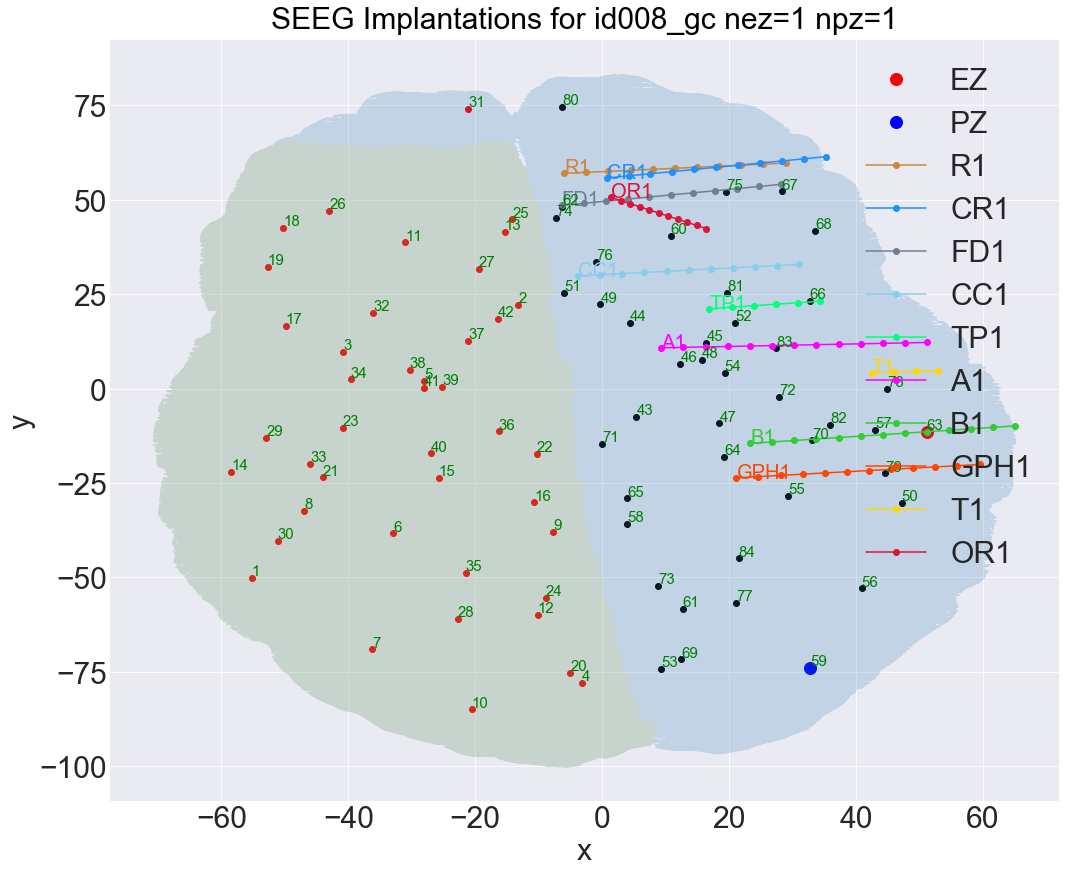

done!


In [58]:
rawplotter.initializefig(figsize=(17,14))
rawplotter.plotcontactsinbrain(cort_surf, region_centers, regions, seeg_xyz, seeg_labels, incr_cont, patient, ezindices, pzindices)

print("done!")

# Testing Ground For Equilibrium Function Finder For Varying X0 Epileptors Model


In [50]:
print(epilept.state_variables)
print(epilept.cvar)
print(initcond.shape)

print(epilept.dfun)
print(6*84)

print initcond.squeeze()[:,0:5]
############
epilept = models.Epileptor()
x0norm = -2.4
x0ez = -1.6
x0pz = -1.8

ezindices = 0
pzindices = 1


# x0init = x0norm
# epilept.x0 = x0norm
# set x0 values (degree of epileptogenicity) for entire model
epilept.x0 = np.ones(84) * x0norm
# set ez region
epilept.x0[ezindices] = x0ez
# set pz regions
epilept.x0[pzindices] = x0pz
initarray = np.repeat(np.array([0.0, 0.0, 3.0, -1.0, 1.0, 0.0]), 84, axis=0)
# initarray = np.array([0.0, 0.0, 3.0, -1.0, 1.0, 0.0])

initcond = tvbsim.initialConditions.get_equilibrium(epilept, initarray)
initcond = initcond.reshape(6, 84, 1)
print(initcond.shape)

print(initcond[:,0:2,:])

['x1', 'y1', 'z', 'x2', 'y2', 'g']
[0 3]
(1, 6, 84, 1)
<bound method Epileptor.dfun of Epileptor(bound=False, value=None)>
504
[[-1.32122342e+00 -1.32122342e+00 -1.32122342e+00 -1.32122342e+00
  -1.32122342e+00]
 [-7.72815656e+00 -7.72815656e+00 -7.72815656e+00 -7.72815656e+00
  -7.72815656e+00]
 [ 2.91510634e+00  2.91510634e+00  2.91510634e+00  2.91510634e+00
   2.91510634e+00]
 [-6.90622884e-01 -6.90622884e-01 -6.90622884e-01 -6.90622884e-01
  -6.90622884e-01]
 [ 1.11245711e-21  1.11245711e-21  1.11245711e-21  1.11245711e-21
   1.11245711e-21]
 [-1.32122342e-01 -1.32122342e-01 -1.32122342e-01 -1.32122342e-01
  -1.32122342e-01]]


In [ ]:
seegindex = np.where(seeg_labels=='TBP6')[0]
print seeg_xyz[seegindex]
print regions[ezindices]
print region_centers[ezindices]
print seeg_labels[seegindex]

In [51]:
print(regions)
print(regions[58])

['ctx-lh-bankssts' 'ctx-lh-caudalanteriorcingulate'
 'ctx-lh-caudalmiddlefrontal' 'ctx-lh-cuneus' 'ctx-lh-entorhinal'
 'ctx-lh-fusiform' 'ctx-lh-inferiorparietal' 'ctx-lh-inferiortemporal'
 'ctx-lh-isthmuscingulate' 'ctx-lh-lateraloccipital'
 'ctx-lh-lateralorbitofrontal' 'ctx-lh-lingual'
 'ctx-lh-medialorbitofrontal' 'ctx-lh-middletemporal'
 'ctx-lh-parahippocampal' 'ctx-lh-paracentral' 'ctx-lh-parsopercularis'
 'ctx-lh-parsorbitalis' 'ctx-lh-parstriangularis' 'ctx-lh-pericalcarine'
 'ctx-lh-postcentral' 'ctx-lh-posteriorcingulate' 'ctx-lh-precentral'
 'ctx-lh-precuneus' 'ctx-lh-rostralanteriorcingulate'
 'ctx-lh-rostralmiddlefrontal' 'ctx-lh-superiorfrontal'
 'ctx-lh-superiorparietal' 'ctx-lh-superiortemporal'
 'ctx-lh-supramarginal' 'ctx-lh-frontalpole' 'ctx-lh-temporalpole'
 'ctx-lh-transversetemporal' 'ctx-lh-insula' 'Left-Cerebellum-Cortex'
 'Left-Thalamus-Proper' 'Left-Caudate' 'Left-Putamen' 'Left-Pallidum'
 'Left-Hippocampus' 'Left-Amygdala' 'Left-Accumbens-area'
 'Right-Thala